In [4]:
import sys
sys.path.insert(0, '/home/jovyan/work/workspace/software/kernellib')
sys.path.insert(0, '/home/jovyan/work/workspace/software/py_esdc')
sys.path.insert(0, '/home/jovyan/work/workspace/projects/2019_sakame/src/')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

from data.make_dataset import ESDCData
from features.dependence import GetXYData
from models.dependence import HSICDependence
from visualization.dependence import plot_raw_variables, plot_sens_mod, plot_sens_angle, plot_sens_scatters
from py_esdc.data import window_xy, get_xy_indices
from py_esdc.utils import xarray2df
from kernellib.dependence import HSIC, RHSIC

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
%matplotlib inline

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'cartopy'

In [ ]:
ESDC_data = xr.open_zarr("/home/jovyan/work/datacube/ESDCv2.0.0/esdc-8d-0.25deg-184x90x90-2.0.0.zarr")

In [2]:
!ls /media/disk/databases/BACI-CABLAB/low_res_data/root_moisture

2001_root_moisture.nc  2005_root_moisture.nc	 2008_root_moisture.nc
2002_root_moisture.nc  2006_root_moisture.nc	 2009_root_moisture.nc
2003_root_moisture.nc  2007_root_moisture.nc	 2010_root_moisture.nc
2004_root_moisture.nc  2008_root_moisture(1).nc  2011_root_moisture.nc


In [ ]:
!rm 'rm '/media/disk/databases/BACI-CABLAB/low_res_data/root_moisture/2008_root_moisture(1).nc'2008_root_moisture(1).nc'

rm: remove write-protected regular file ‘/media/disk/databases/BACI-CABLAB/low_res_data/root_moisture/2008_root_moisture(1).nc’? 

### Extract ESDC Data

In [3]:
# variables for the experiment
variables = [
    'gross_primary_productivity',
    'root_moisture'
]

year = '2002'
start_time = year
end_time = year
subsection = 'europe'
data_path = '/media/disk/databases/BACI-CABLAB/low_res_data/'
minicube_path = '/home/emmanuel/projects/2019_sakame/data/processed/nb_data/'
figures_path = '/home/emmanuel/projects/2019_sakame/reports/figures/dependence/'

In [4]:
# Initialize data class
esdc_data = ESDCData(
    variables=variables,
    time_frame=[start_time, end_time],
    subsection=subsection,
    minicube_path=minicube_path
)

# Extract data
data = esdc_data.extract_datacube()

ValueError: cannot reindex or align along dimension 'time' because the index has duplicate values

In [6]:
# Extract summertime months
subset = data.sel(time=slice(f'{year}-06', f'{year}-08'))

# extract dates
dates = subset.time.data

# Take GPP and land surface temperature
gpp_data = subset.gross_primary_productivity.where(subset.mask==1)
sm_data = subset.soil_moisture.where(subset.mask==1)



n_time, n_lat, n_lon = gpp_data.shape

### Plot Raw Variables

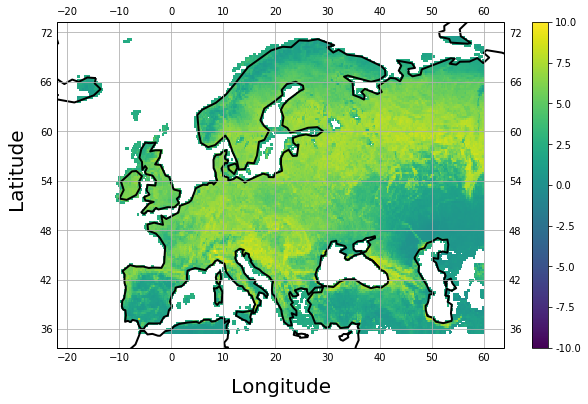

In [7]:
plot_raw_variables(gpp_data, year, 'gross_primary_productivity', mean=True)

<Figure size 720x720 with 0 Axes>

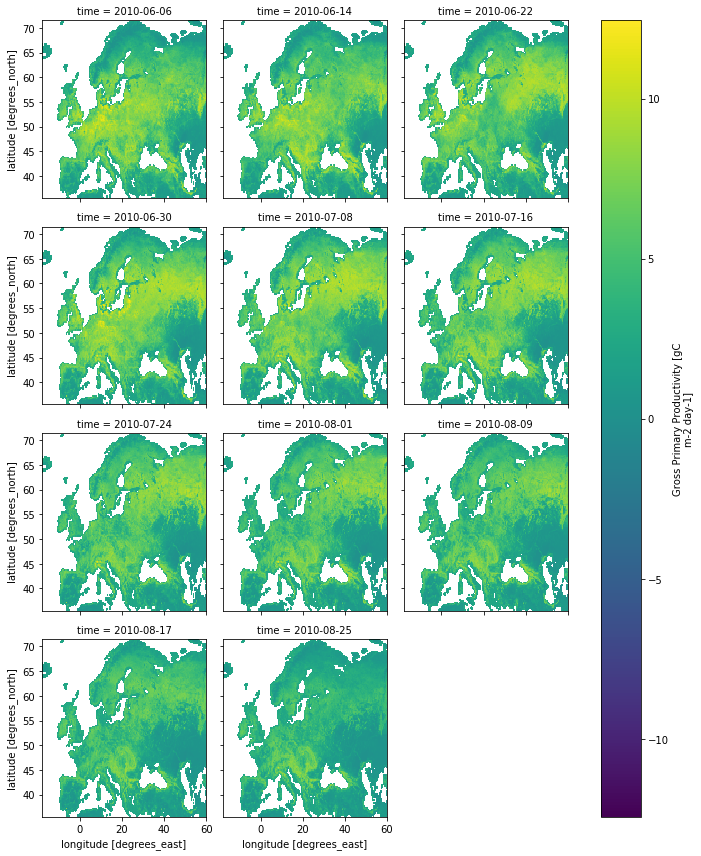

In [8]:
plot_raw_variables(gpp_data, year, 'gross_primary_productivity', mean=False)

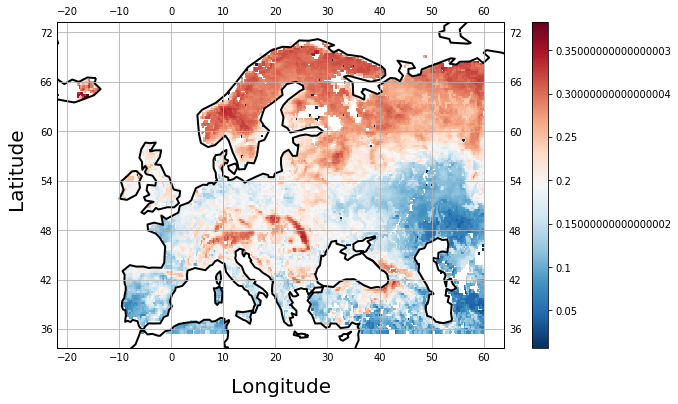

In [9]:
plot_raw_variables(sm_data, year, 'soil_moisture', mean=True)

<Figure size 720x720 with 0 Axes>

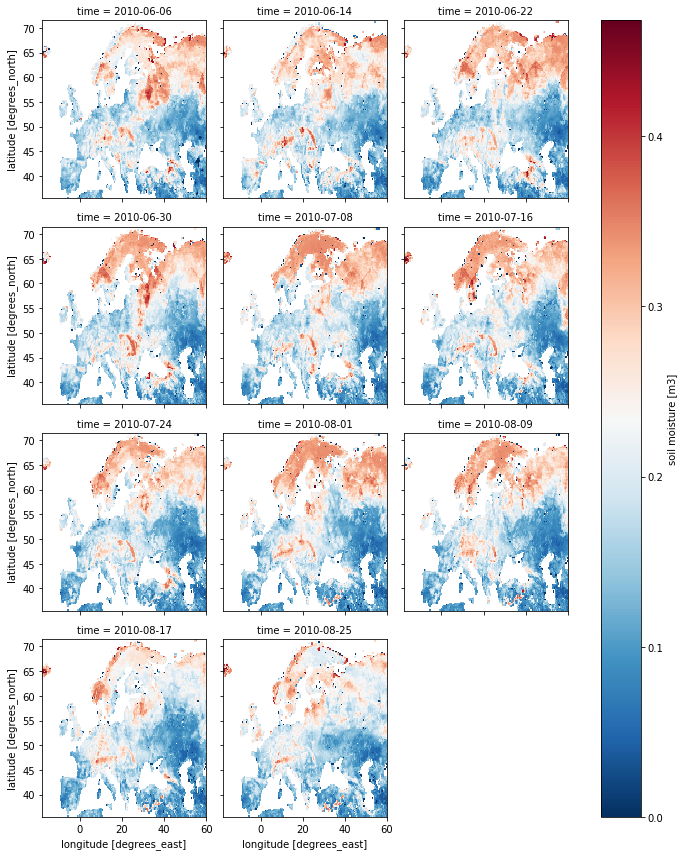

In [10]:
plot_raw_variables(sm_data, year, 'soil_moisture', mean=False)

### Conversion: Pandas DataFrame & Xarray Dataset

In [11]:
# Convert df to xarray
def create_xarray(xr_df, variable='gross_primary_productivity'):
    
    xr_df = xr_df.reset_index().pivot_table(index=['lat', 'lon'], values=variable)
    
    return xr_df.to_xarray()

In [12]:
# convert xarray to df
def create_df(xr_array, variable='gross_primary_productivity'):
    """Function to convert an xarray into a dataframe.
    This also preserves the lat and lon coordinates."""
    # Subset
    xr_df = subset.where(subset.mask==1).mean(dim='time', skipna=True)[variable].to_dataframe(variable).dropna()
    # drop mask
    xr_df = xr_df.drop('mask', 1)
    
    # Remove duplicates
    xr_df = xr_df.reset_index().pivot_table(
        index=range(xr_df.shape[0]),
        values=[variable, 'lat', 'lon']
    ).drop_duplicates()
    
    return xr_df

# Convert df to xarray
def create_xarray(xr_df, variable='gross_primary_productivity'):
    
    xr_df = xr_df.reset_index().pivot_table(index=['lat', 'lon'], values=variable)
    
    return xr_df.to_xarray()

#### Convert XARRAY to DATAFRAME

In [13]:
variable = 'gross_primary_productivity'

gpp_df = create_df(subset, variable)

gpp_df.head()

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


gross_primary_productivity     lat     lon
0                    2.173877  71.375  51.875
1                    2.111698  71.375  52.125
2                    1.641929  71.375  52.375
3                    1.602117  71.375  52.625
4                    1.367754  71.375  52.875

#### Convert DATAFRAME to XARRAY

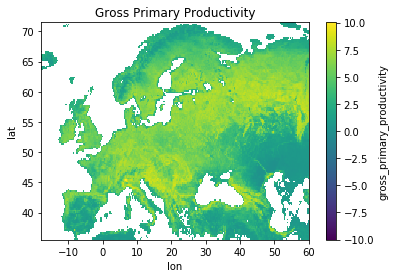

In [14]:
gpp_xr = create_xarray(gpp_df, variable)

fig, ax = plt.subplots()

gpp_xr[variable].plot.imshow(ax=ax, cmap='viridis', robust=False)
ax.set_title('Gross Primary Productivity')
plt.show()

In [15]:
gpp_df = create_df(subset, variable='gross_primary_productivity')
sm_df = create_df(subset, variable='soil_moisture')

var_df = gpp_df.merge(sm_df)
var_df = var_df.dropna()



/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [16]:
Y = var_df['soil_moisture'].values
X = var_df['gross_primary_productivity'].values
lat = var_df['lat']
lon = var_df['lon']

In [17]:
print(X.shape)

(23770,)


## Preliminary Data Exploration

### Extract Data with time as dimension

In [16]:
derX, derY = dict(), dict()
mod_sens, ang_sens = dict(), dict()

## Experiment I - Linear HSIC 

In [17]:
subsample = 10000
normalize = True

# Initialize Feature-Getter Class
data_features = GetXYData(
    subsample=subsample,
    normalize=normalize
)

# Extract variables and coordiantes
X, Y, lat, lon = data_features.set_XY(subset)

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


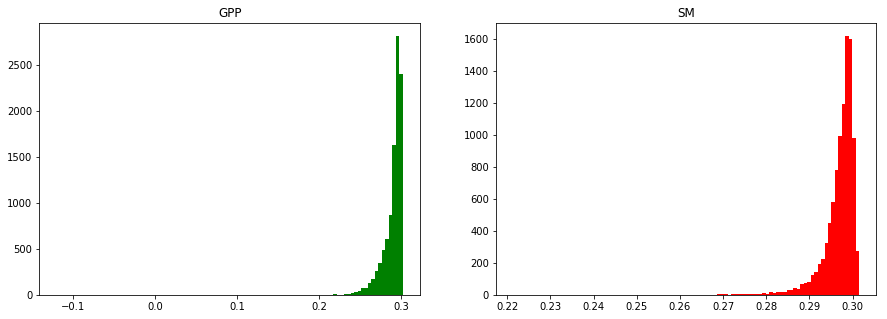

In [18]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].hist(X.mean(axis=1), bins=100, color='green')
# ax[0].hist(X_sub.mean(axis=1), bins=100, color='green')
ax[0].set_title('GPP')

ax[1].hist(Y.mean(axis=1), bins=100, color='red')
# ax[1].hist(Y_sub.mean(axis=1), bins=100, color='red')
ax[1].set_title('SM')

plt.show()

In [19]:
%%time

model = 'linear'
subsample = 1000

lhsic_model = HSICDependence(
    model=model,
    subsample=subsample
)

# Fit HSIC model to data
lhsic_model.fit_model(X, Y)

CPU times: user 2min 29s, sys: 20.4 s, total: 2min 50s
Wall time: 8.09 s


In [20]:
print(f"HSIC: {lhsic_model.get_hsic():.4f}")

HSIC: 0.0001


In [21]:
%%time
derX['lhsic'], derY['lhsic'] = lhsic_model.get_derivative()

CPU times: user 2min 19s, sys: 15.9 s, total: 2min 35s
Wall time: 6.94 s


In [22]:
%%time
mod_sens['lhsic'] = lhsic_model.get_mod()
ang_sens['lhsic'] = lhsic_model.get_angle()

CPU times: user 30.5 ms, sys: 179 ms, total: 209 ms
Wall time: 7.47 ms


In [23]:
print(X.shape, ang_sens['lhsic'].shape)

(10000, 11) (10000, 11)


### Scatter Plot - Normalized Data

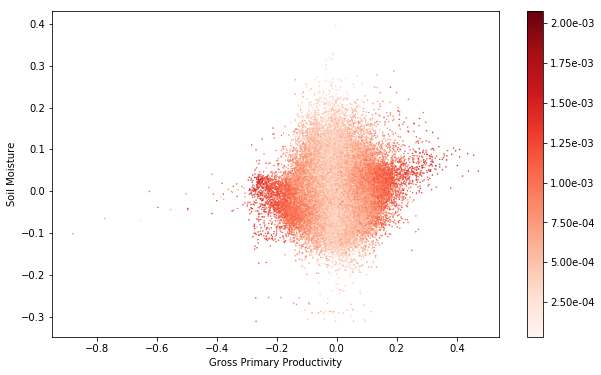

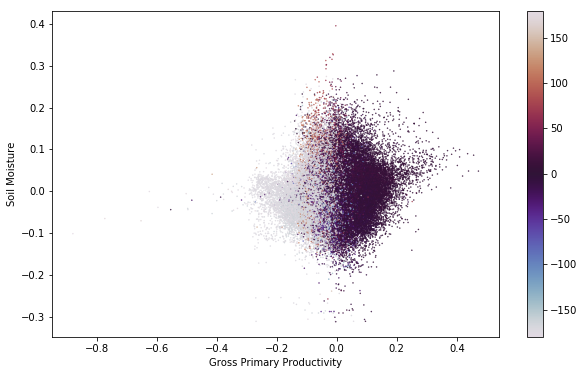

In [24]:
plot_sens_scatters(X, Y, mod_sens['lhsic'], ang_sens['lhsic'], year=year, model='lhsic', mean=False, normed=True)

### Convert Data to Xarray

In [27]:
mod_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': mod_sens['lhsic'][:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    mod_data.append(vis_xr)

mod_data = xr.concat(mod_data, dim='time')


## Maps

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


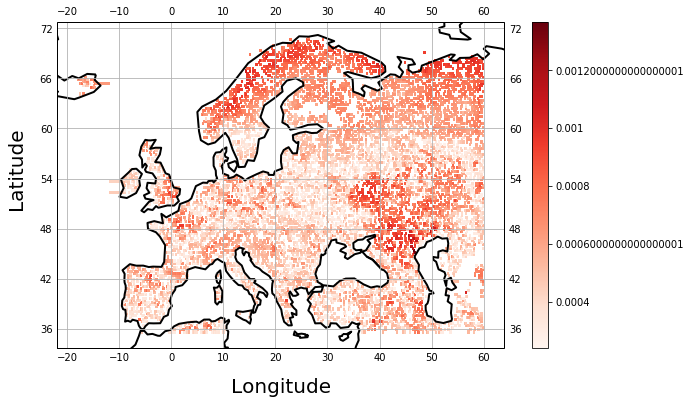

In [28]:
plot_sens_mod(mod_data.sens, year, model='lhsic', mean=True)

<Figure size 720x720 with 0 Axes>

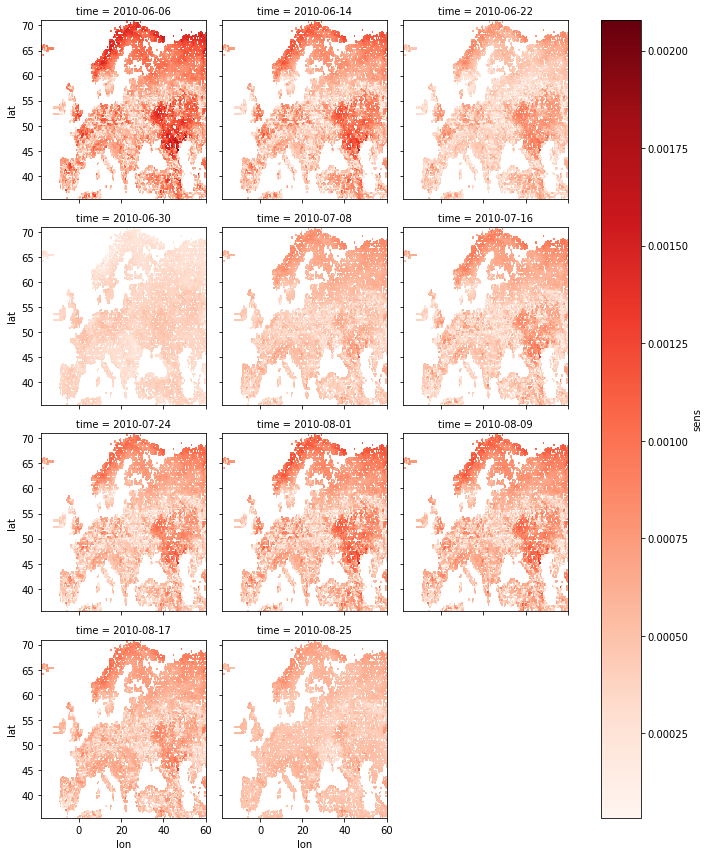

In [29]:
plot_sens_mod(mod_data.sens, year, model='lhsic', mean=False)

### Angle

In [30]:
%%time

test_mod = MinMaxScaler().fit_transform(mod_sens['lhsic'])
test_ang = MinMaxScaler(feature_range=(-1, 1)).fit_transform(ang_sens['lhsic'])
print(test_mod.shape, test_ang.shape)
test_data = test_mod * test_ang

# print(test_data.shape)
# data = test_data.mean(axis=1) / np.abs(test_data).max()
# data = np.sqrt( np.abs(data)) * np.sign(data) 


ang_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': test_data[:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    ang_data.append(vis_xr)

ang_data = xr.concat(ang_data, dim='time')

(10000, 11) (10000, 11)
CPU times: user 1.23 s, sys: 35.2 ms, total: 1.26 s
Wall time: 1.26 s


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


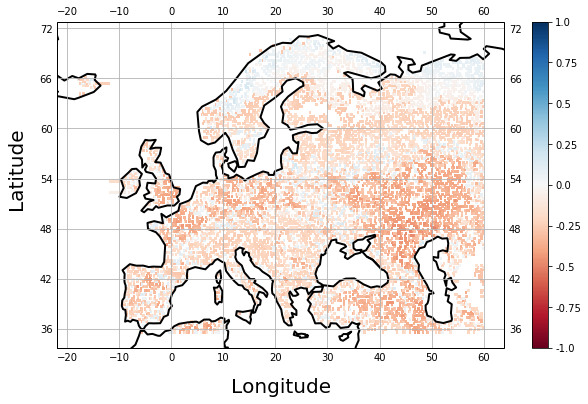

In [32]:
plot_sens_angle(ang_data.sens, year, model='lhsic', mean=True)

<Figure size 720x720 with 0 Axes>

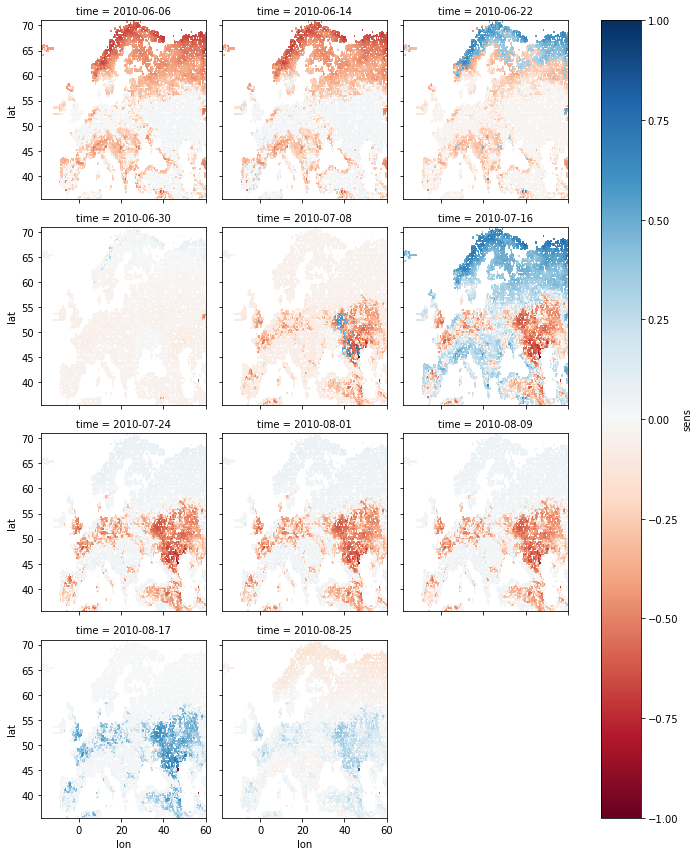

In [34]:
plot_sens_angle(ang_data.sens, year, model='lhsic', mean=False)

## Experiment II - HSIC (RBF Kernel)

In [55]:
subsample = 10000
normalize = True

# Initialize Feature-Getter Class
data_features = GetXYData(
    subsample=subsample,
    normalize=normalize
)

# Extract variables and coordiantes
X, Y, lat, lon = data_features.set_XY(subset)

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


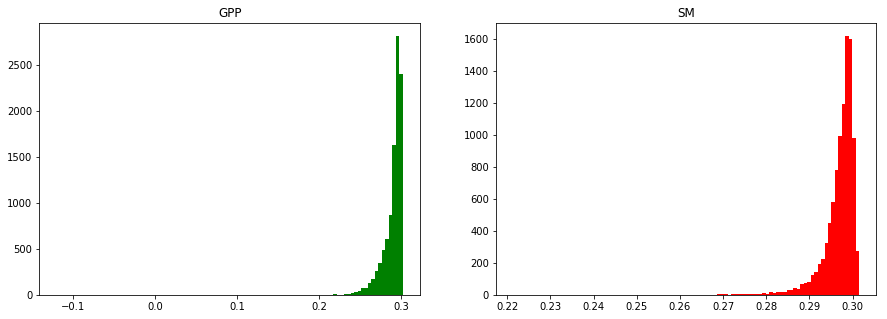

In [56]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].hist(X.mean(axis=1), bins=100, color='green')
# ax[0].hist(X_sub.mean(axis=1), bins=100, color='green')
ax[0].set_title('GPP')

ax[1].hist(Y.mean(axis=1), bins=100, color='red')
# ax[1].hist(Y_sub.mean(axis=1), bins=100, color='red')
ax[1].set_title('SM')

plt.show()

In [57]:
%%time

model = 'rbf'
subsample = 1000

hsic_model = HSICDependence(
    model=model,
    subsample=subsample,
)

# Fit HSIC model to data
hsic_model.fit_model(X, Y)

CPU times: user 2min 26s, sys: 32.4 s, total: 2min 58s
Wall time: 9.38 s


In [59]:
print(f"HSIC: {hsic_model.get_hsic():.4f}")

HSIC: 0.0065


In [58]:
derX['hsic'], derY['hsic'] = hsic_model.get_derivative()

In [60]:
mod_sens['hsic'] = hsic_model.get_mod()
ang_sens['hsic'] = hsic_model.get_angle()

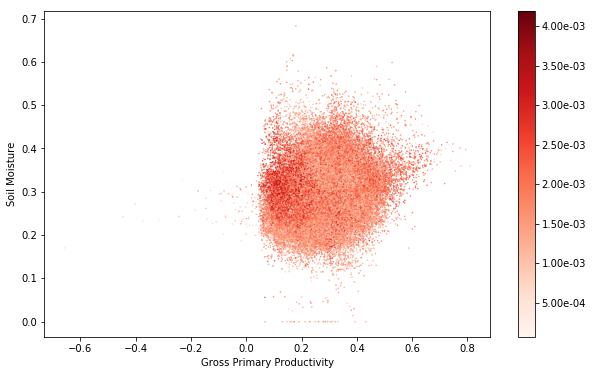

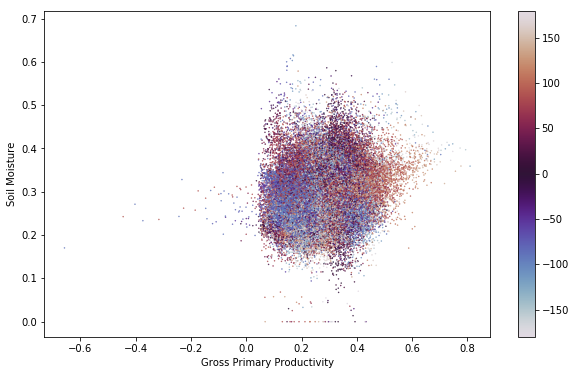

In [61]:
plot_sens_scatters(X, Y, mod_sens['hsic'], ang_sens['hsic'], year=year, model='hsic', mean=False, normed=True)

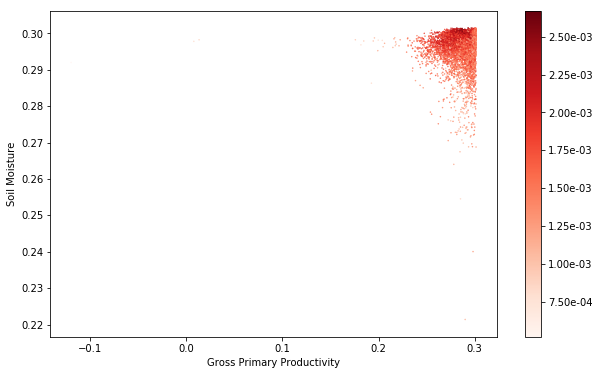

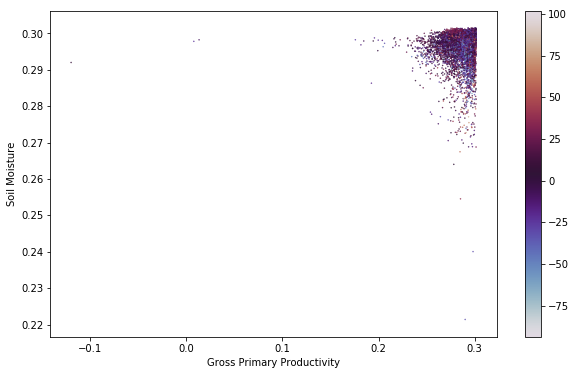

In [62]:
plot_sens_scatters(X.mean(axis=1), Y.mean(axis=1), mod_sens['hsic'].mean(axis=1), ang_sens['hsic'].mean(axis=1), year=year, model='hsic', mean=True, normed=True)

In [63]:
mod_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': mod_sens['hsic'][:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    mod_data.append(vis_xr)

mod_data = xr.concat(mod_data, dim='time')


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


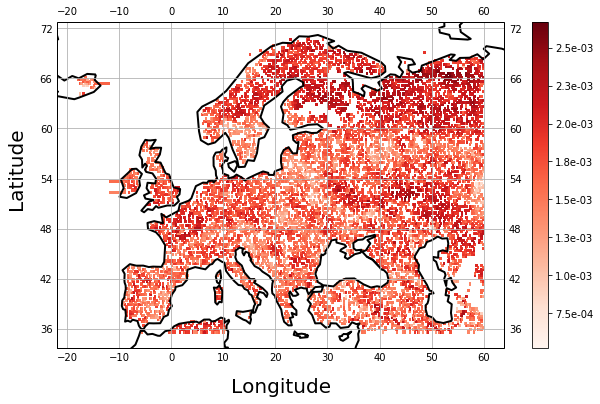

In [64]:
plot_sens_mod(mod_data.sens, year, model='hsic', mean=True)

<Figure size 720x720 with 0 Axes>

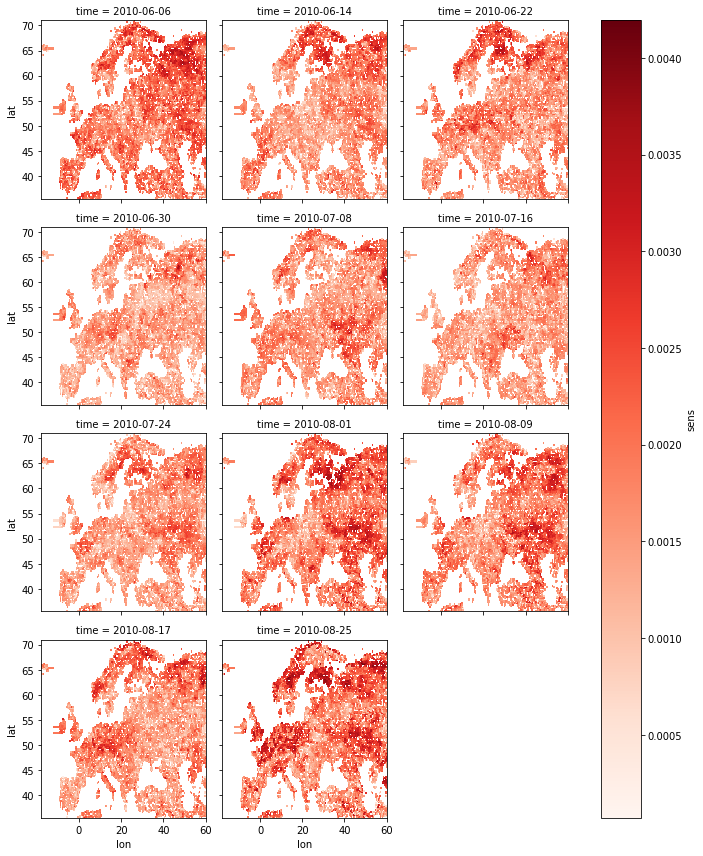

In [65]:
plot_sens_mod(mod_data.sens, year, model='hsic', mean=False)

In [66]:
%%time

test_mod = MinMaxScaler().fit_transform(mod_sens['hsic'])
test_ang = MinMaxScaler(feature_range=(-1, 1)).fit_transform(ang_sens['hsic'])
print(test_mod.shape, test_ang.shape)
test_data = test_mod * test_ang

# print(test_data.shape)
# data = test_data.mean(axis=1) / np.abs(test_data).max()
# data = np.sqrt( np.abs(data)) * np.sign(data) 


ang_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': test_data[:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    ang_data.append(vis_xr)

ang_data = xr.concat(ang_data, dim='time')

(10000, 11) (10000, 11)
CPU times: user 1.15 s, sys: 24.9 ms, total: 1.17 s
Wall time: 1.17 s


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


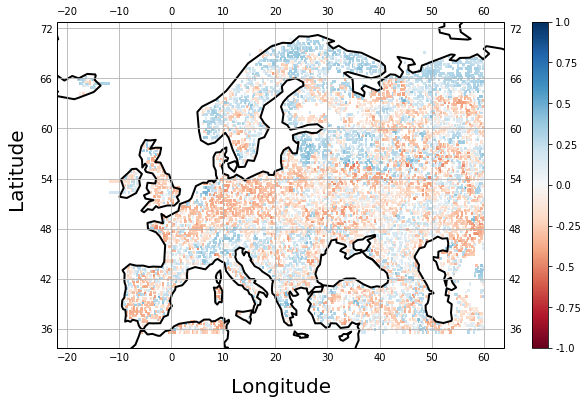

In [67]:
plot_sens_angle(ang_data.sens, year, model='hsic', mean=True)

<Figure size 720x720 with 0 Axes>

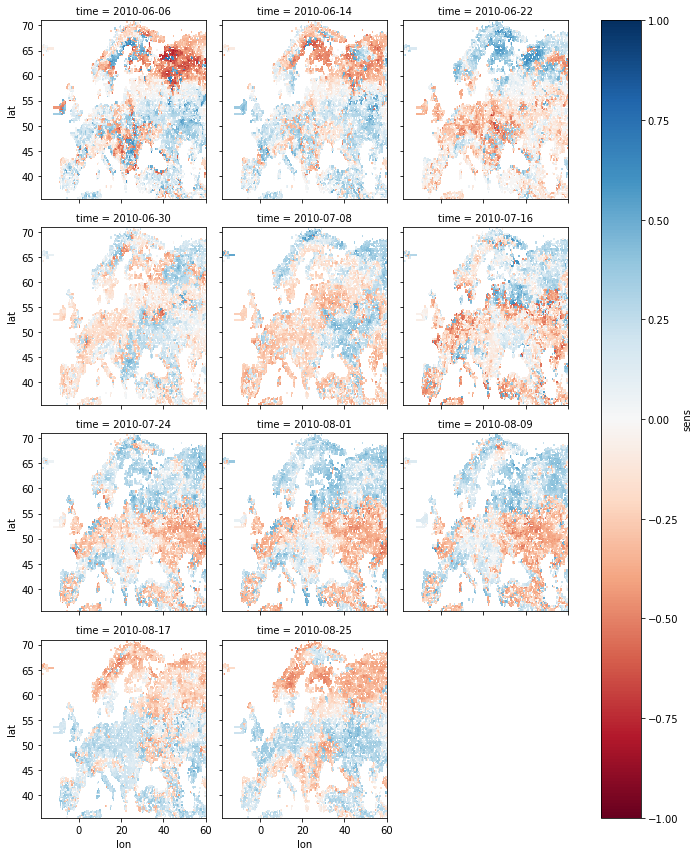

In [68]:
plot_sens_angle(ang_data.sens, year, model='hsic', mean=False)

## Experiment III - Randomized HSIC

In [35]:
subsample = None
normalize = True

# Initialize Feature-Getter Class
data_features = GetXYData(
    subsample=subsample,
    normalize=normalize
)

# Extract variables and coordiantes
X, Y, lat, lon = data_features.set_XY(subset)

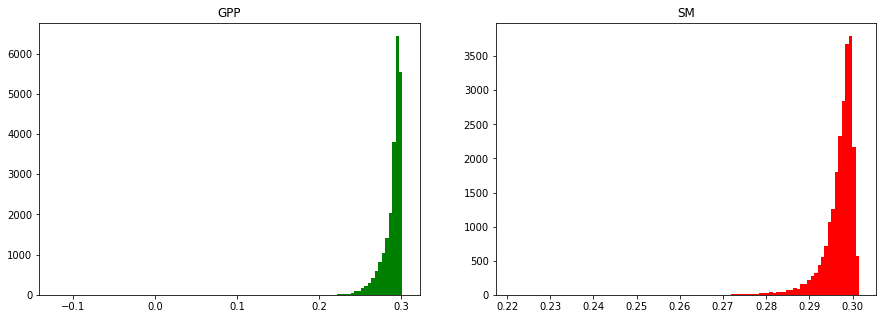

In [36]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].hist(X.mean(axis=1), bins=100, color='green')
# ax[0].hist(X_sub.mean(axis=1), bins=100, color='green')
ax[0].set_title('GPP')

ax[1].hist(Y.mean(axis=1), bins=100, color='red')
# ax[1].hist(Y_sub.mean(axis=1), bins=100, color='red')
ax[1].set_title('SM')

plt.show()

In [37]:
%%time

model = 'rff'
subsample = 1000
n_features = 2000

rhsic_model = HSICDependence(
    model=model,
    subsample=subsample,
    n_features=n_features
)

# Fit HSIC model to data
rhsic_model.fit_model(X, Y)

CPU times: user 53.1 s, sys: 45.9 s, total: 1min 38s
Wall time: 23.1 s


In [38]:
print(f"RHSIC: {rhsic_model.get_hsic():.4f}")

RHSIC: 0.0066


In [39]:
%%time
derX['rhsic'], derY['rhsic'] = rhsic_model.get_derivative()

CPU times: user 15min 32s, sys: 17min 48s, total: 33min 21s
Wall time: 1min 31s


In [40]:
%%time
mod_sens['rhsic'] = rhsic_model.get_mod()
ang_sens['rhsic'] = rhsic_model.get_angle()

CPU times: user 18.3 ms, sys: 6.15 ms, total: 24.4 ms
Wall time: 24.1 ms


### Scatter Plot - Normalized Data

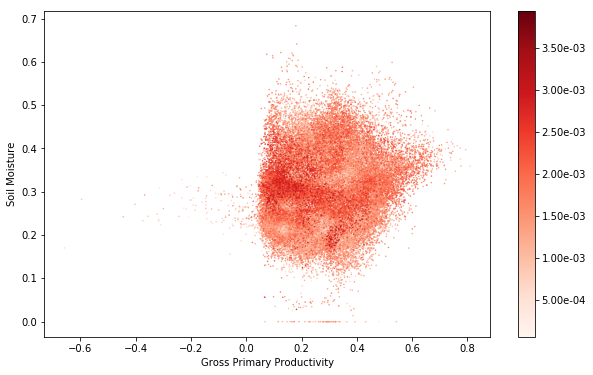

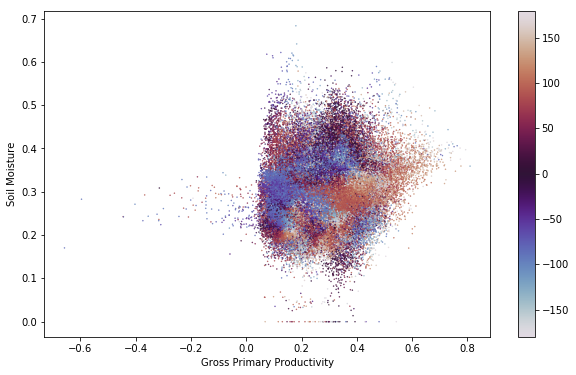

In [41]:
plot_sens_scatters(X, Y, mod_sens['rhsic'], ang_sens['rhsic'], year=year, model='rhsic', mean=False, normed=True)

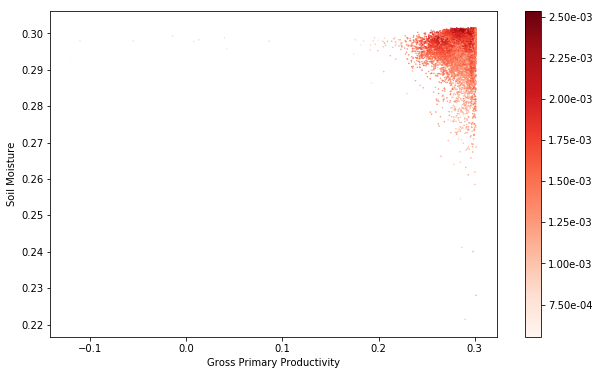

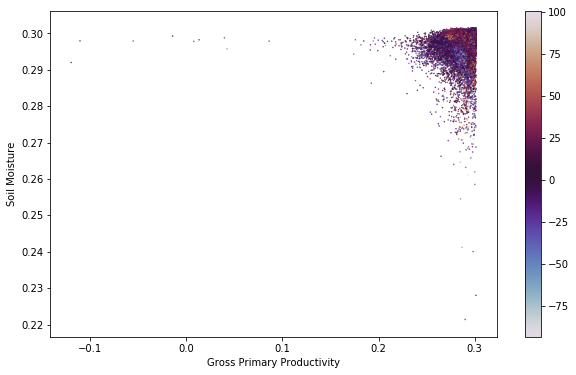

In [42]:
plot_sens_scatters(X.mean(axis=1), Y.mean(axis=1), mod_sens['rhsic'].mean(axis=1), ang_sens['rhsic'].mean(axis=1), year=year, model='rhsic', mean=True, normed=True)

In [43]:
mod_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': mod_sens['rhsic'][:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    mod_data.append(vis_xr)

mod_data = xr.concat(mod_data, dim='time')


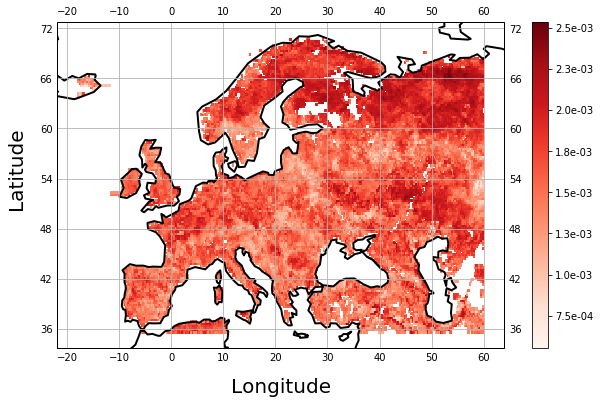

In [50]:
plot_sens_mod(mod_data.sens, year, model='rhsic', mean=True)

<Figure size 720x720 with 0 Axes>

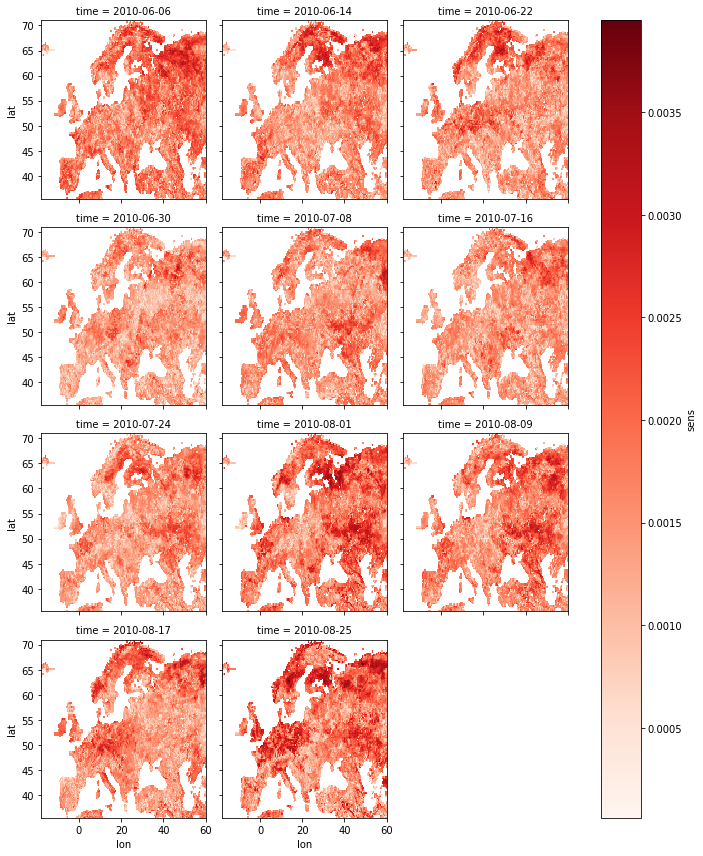

In [51]:
plot_sens_mod(mod_data.sens, year, model='rhsic', mean=False)

In [52]:
%%time

test_mod = MinMaxScaler().fit_transform(mod_sens['rhsic'])
test_ang = MinMaxScaler(feature_range=(-1, 1)).fit_transform(ang_sens['rhsic'])
print(test_mod.shape, test_ang.shape)
test_data = test_mod * test_ang

# print(test_data.shape)
# data = test_data.mean(axis=1) / np.abs(test_data).max()
# data = np.sqrt( np.abs(data)) * np.sign(data) 


ang_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': test_data[:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    ang_data.append(vis_xr)

ang_data = xr.concat(ang_data, dim='time')

(23090, 11) (23090, 11)
CPU times: user 1.21 s, sys: 42.2 ms, total: 1.26 s
Wall time: 1.25 s


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


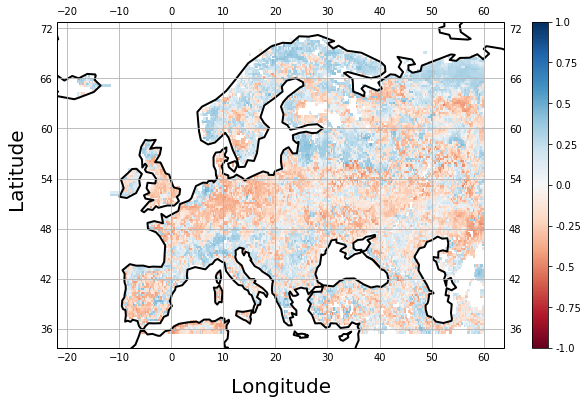

In [53]:
plot_sens_angle(ang_data.sens, year, model='rhsic', mean=True)

<Figure size 720x720 with 0 Axes>

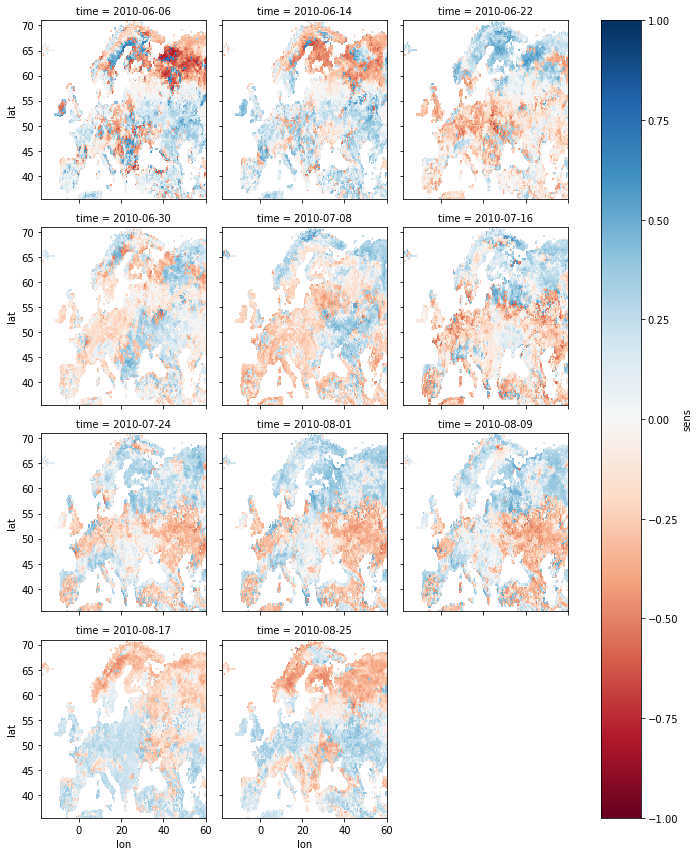

In [54]:
plot_sens_angle(ang_data.sens, year, model='rhsic', mean=False)

### Sensitivity

Converting Cartesian to Polar Coordinates

* Modulus: $r = \sqrt{x^2 + y^2}$
* Angle: $\theta = \arctan{\frac{y}{x}}$

In [271]:
%%time

# Calculate the Modulus of the Derivatives
mod_sens['rhsic'] = np.sqrt(np.abs(derX['rhsic']) + np.abs(derY['rhsic']))

# Calculate the Direction of the Derivatives
ang_sens['rhsic'] = np.arctan2( 
    np.abs(derY['rhsic']), 
    np.abs(derX['rhsic']))

# Convert radians to degrees
ang_sens['rhsic'] = np.rad2deg(ang_sens['rhsic'])

CPU times: user 9.88 ms, sys: 2.84 ms, total: 12.7 ms
Wall time: 12.1 ms
